# Two stage hierarchical analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

import pandas as pd
from chainconsumer import ChainConsumer, Chain, PlotConfig


from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hierarchical model

Consider data $d$ and a hierarchical model with latent- and hyper-parameters $\mathbf{x}$ and $y$, respectively.

$$p(\mathbf{x}, y | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | y) \cdot p(y)\,.$$

The likelihood and priors are

\begin{align*}
    p(d | x_i)\sim \,&\mathcal{N}(\mu=2, \sigma=5) \\
    p(x_i | y) \sim \,&\mathcal{N}(\mu=0, \sigma=e^{y/2}) \\
    p(y): \; y \sim \,&\mathcal{N}(\mu=0, \sigma=3)\,. \\
\end{align*}

In [6]:
# store attributes of distributions

# dimension of x random variable
x_ndim = 9

# likelihood
like_mean = jnp.ones(x_ndim) * 2.
like_stdev = jnp.ones(x_ndim) * 5.

# prior
prior_mean = 0.
prior_stdev = jit(lambda y: jnp.exp(y / 2))

# hyper-prior
hyper_prior_mean = 0.
hyper_prior_stdev = 3.

In [7]:
# likelihood function
@jit
def lnlike(x):
    return jnp.sum(js.stats.norm.logpdf(x, loc=like_mean, scale=like_stdev))

# prior
@jit
def lnprior(x, y):
    return jnp.sum(js.stats.norm.logpdf(x, loc=prior_mean, scale=prior_stdev(y)))

# hyper-prior
@jit
def ln_hyperprior(y):
    return js.stats.norm.logpdf(y, loc=hyper_prior_mean, scale=hyper_prior_stdev)

# posterior
@jit
def lnpost(x, y):
    return lnlike(x) + lnprior(x, y) + ln_hyperprior(y)

## Sample with HMC

In [8]:
# naive sampling model
def sampling_model():
    x = numpyro.sample('x', dist.Uniform(-10., 10.).expand((x_ndim,)))
    y = numpyro.sample('y', dist.Uniform(-10., 10.))
    numpyro.factor('lnpost', lnpost(x, y))

nuts_kernel = numpyro.infer.NUTS(model=sampling_model,
                                 dense_mass=False)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e3),
                          num_samples=int(1e5))
mcmc.run(jr.key(170817))
samples_dict = mcmc.get_samples()
samples = jnp.concatenate((samples_dict['x'], jnp.array([samples_dict['y']]).T), axis=1)

sample: 100%|██████████| 101000/101000 [00:21<00:00, 4676.63it/s, 15 steps of size 2.51e-01. acc. prob=0.79]


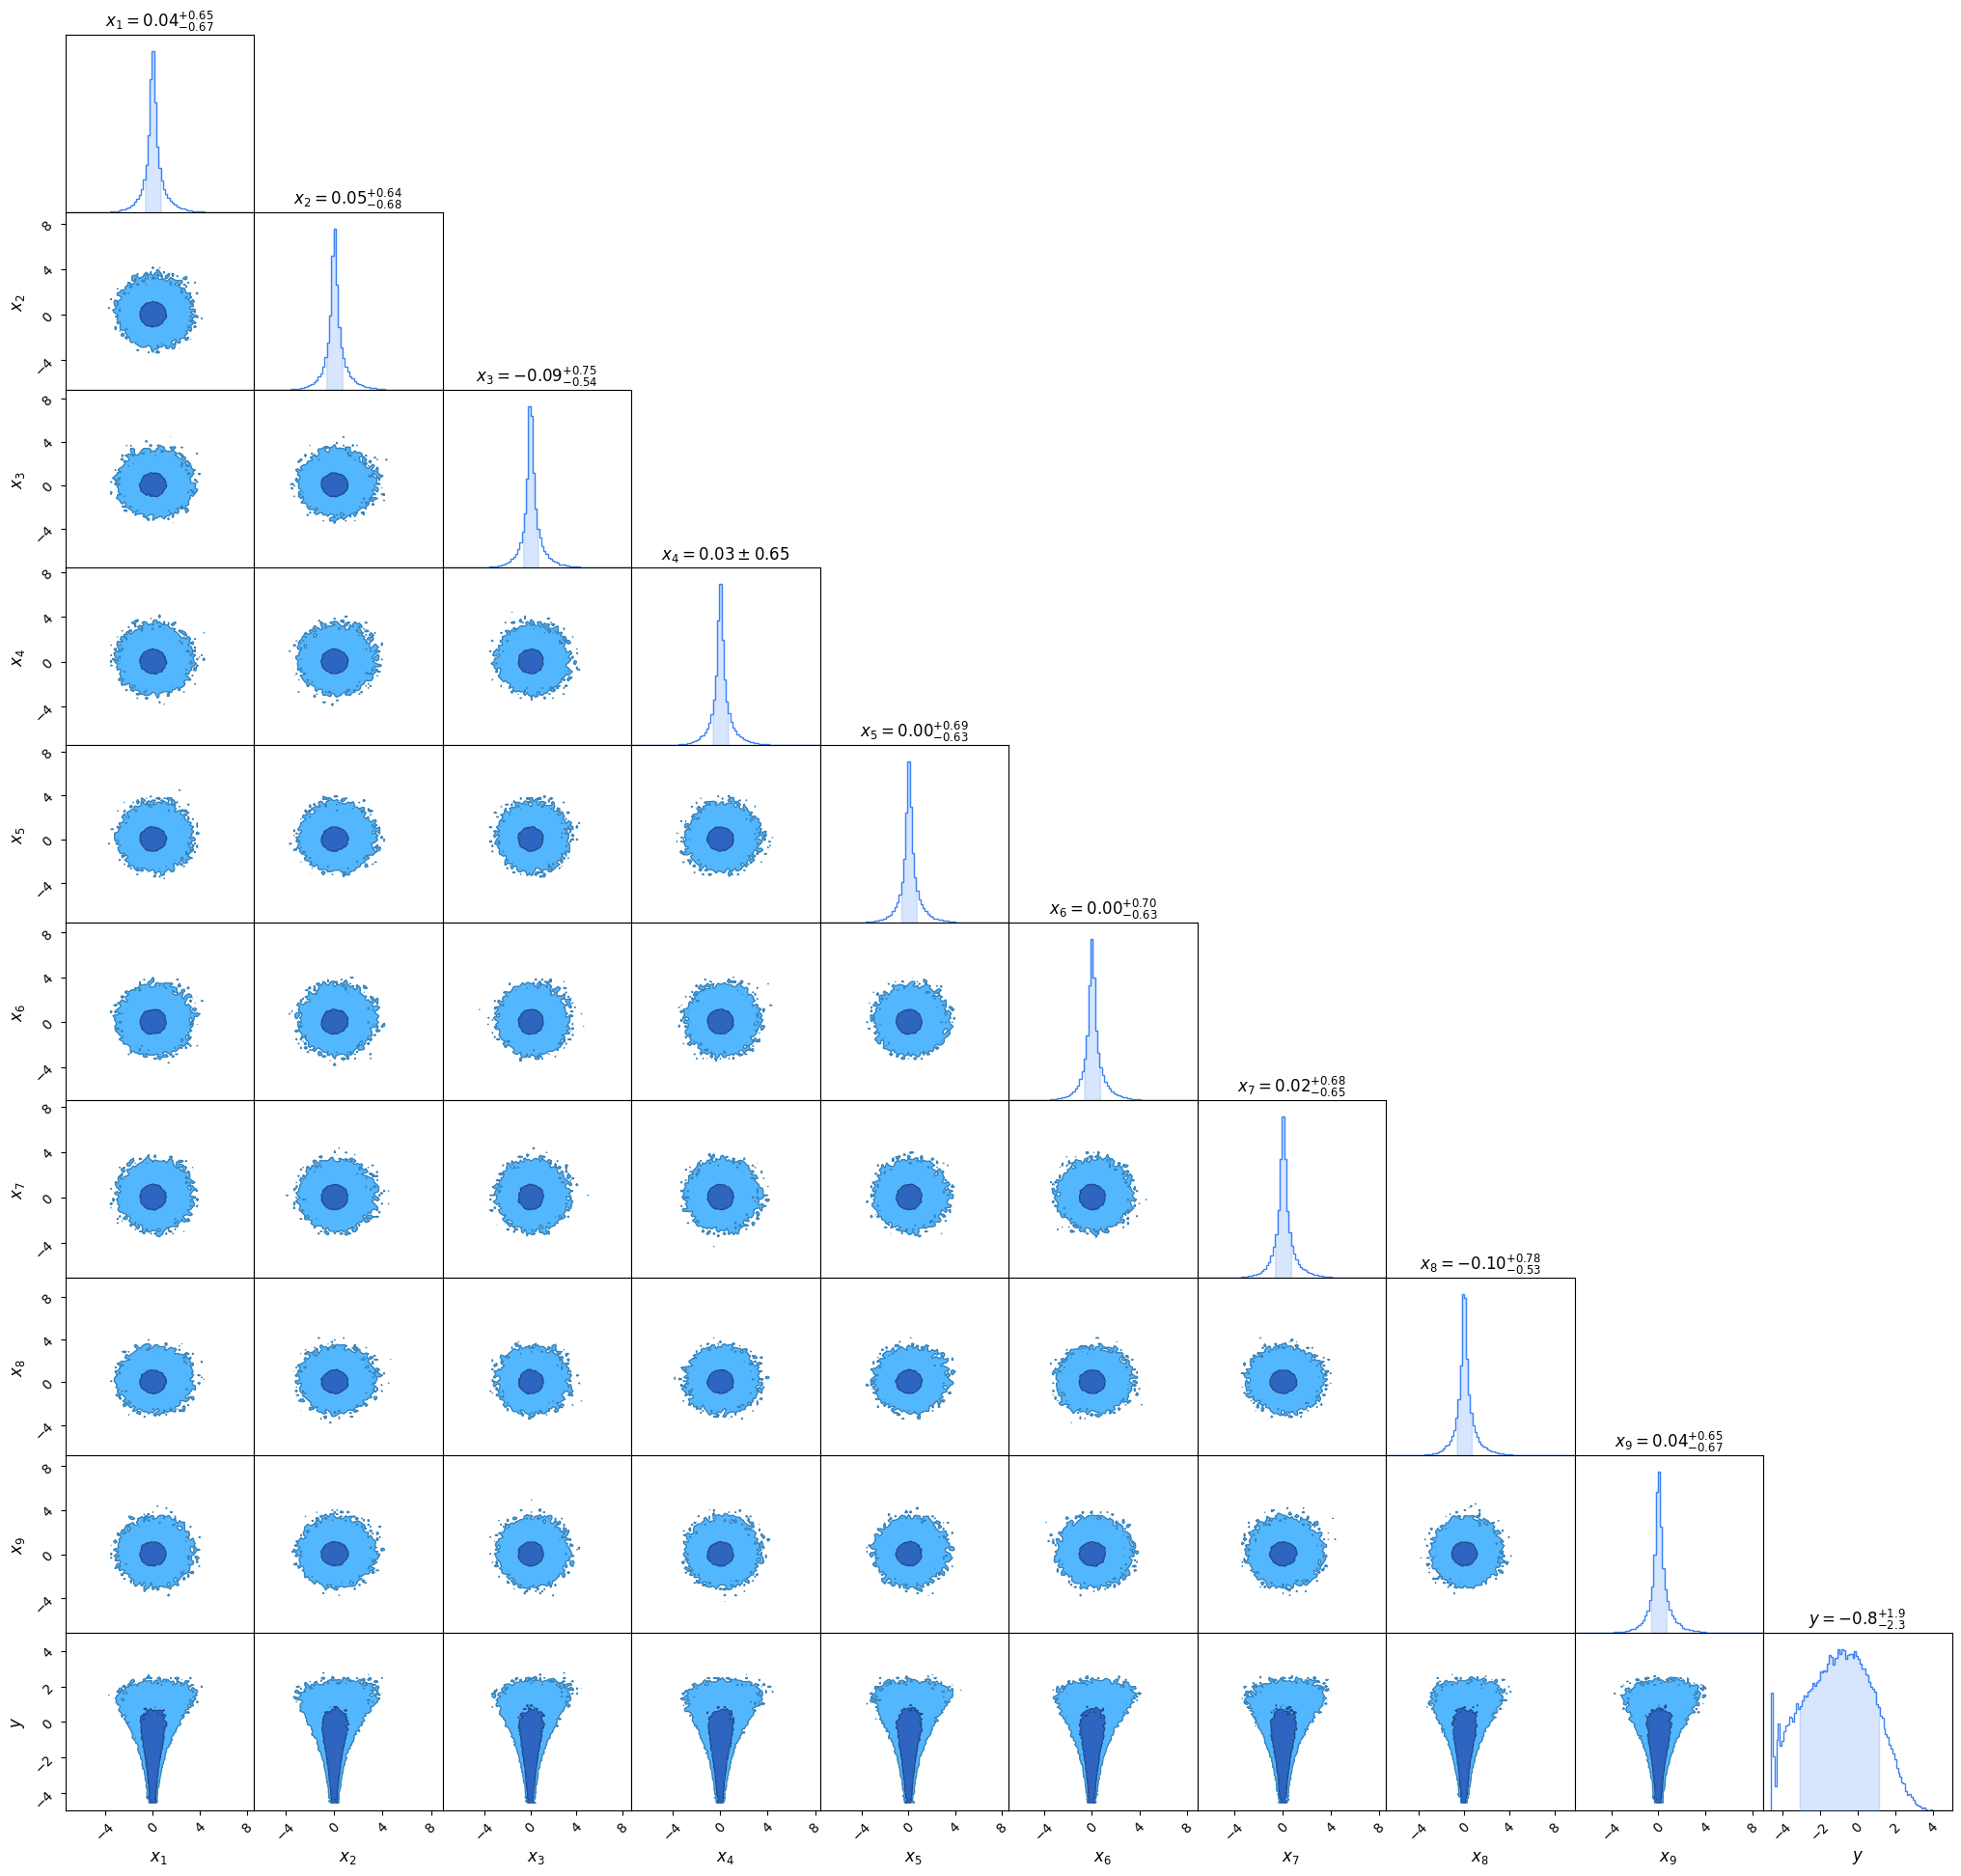

In [9]:
# plot funnel
x_labels = np.array([rf'$x_{i}$' for i in range(1, x_ndim + 1)])
labels = np.concatenate((x_labels, np.array([r'$y$'])))

cc = ChainConsumer()
df = pd.DataFrame(samples, columns=labels)
cc.add_chain(Chain(samples=df, name='HMC', smooth=0))
cc.set_plot_config(PlotConfig(extents={labels[-1]: (-5, 5)}))
fig = cc.plotter.plot()

## Sample under standardizing transformation

Standardize according to (hyper-) prior.

\begin{align*}
    p(d | x_i): \; x_i \sim \,&\mathcal{N}(\mu=2, \sigma=5) \\
    p(x_i | y): \; x_i \sim \,&\mathcal{N}(\mu=0, \sigma=e^{y/2}) \\
    p(y): \; y \sim \,&\mathcal{N}(\mu=0, \sigma=3) \\
\end{align*}

In [10]:
# standardized sampling model
def standard_sampling_model():

    # draw parameters from standard normal
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_ndim,)))
    y_standard = numpyro.sample('y_standard', dist.Normal())
    
    # transform parameters according to their prior distributions
    y = numpyro.deterministic('y', hyper_prior_mean + hyper_prior_stdev * y_standard)
    x = numpyro.deterministic('x', prior_mean + prior_stdev(y) * x_standard)
    
    numpyro.factor('lnlike', lnlike(x))

standard_nuts_kernel = numpyro.infer.NUTS(model=standard_sampling_model,
                                          dense_mass=True)
standard_mcmc = numpyro.infer.MCMC(sampler=standard_nuts_kernel,
                                   num_warmup=int(1e3),
                                   num_samples=int(1e5))
standard_mcmc.run(jr.key(170817))
standard_samples_dict = standard_mcmc.get_samples()
standard_samples = jnp.concatenate((standard_samples_dict['x'], jnp.array([standard_samples_dict['y']]).T), axis=1)

sample: 100%|██████████| 101000/101000 [00:24<00:00, 4204.59it/s, 7 steps of size 5.73e-01. acc. prob=0.89]


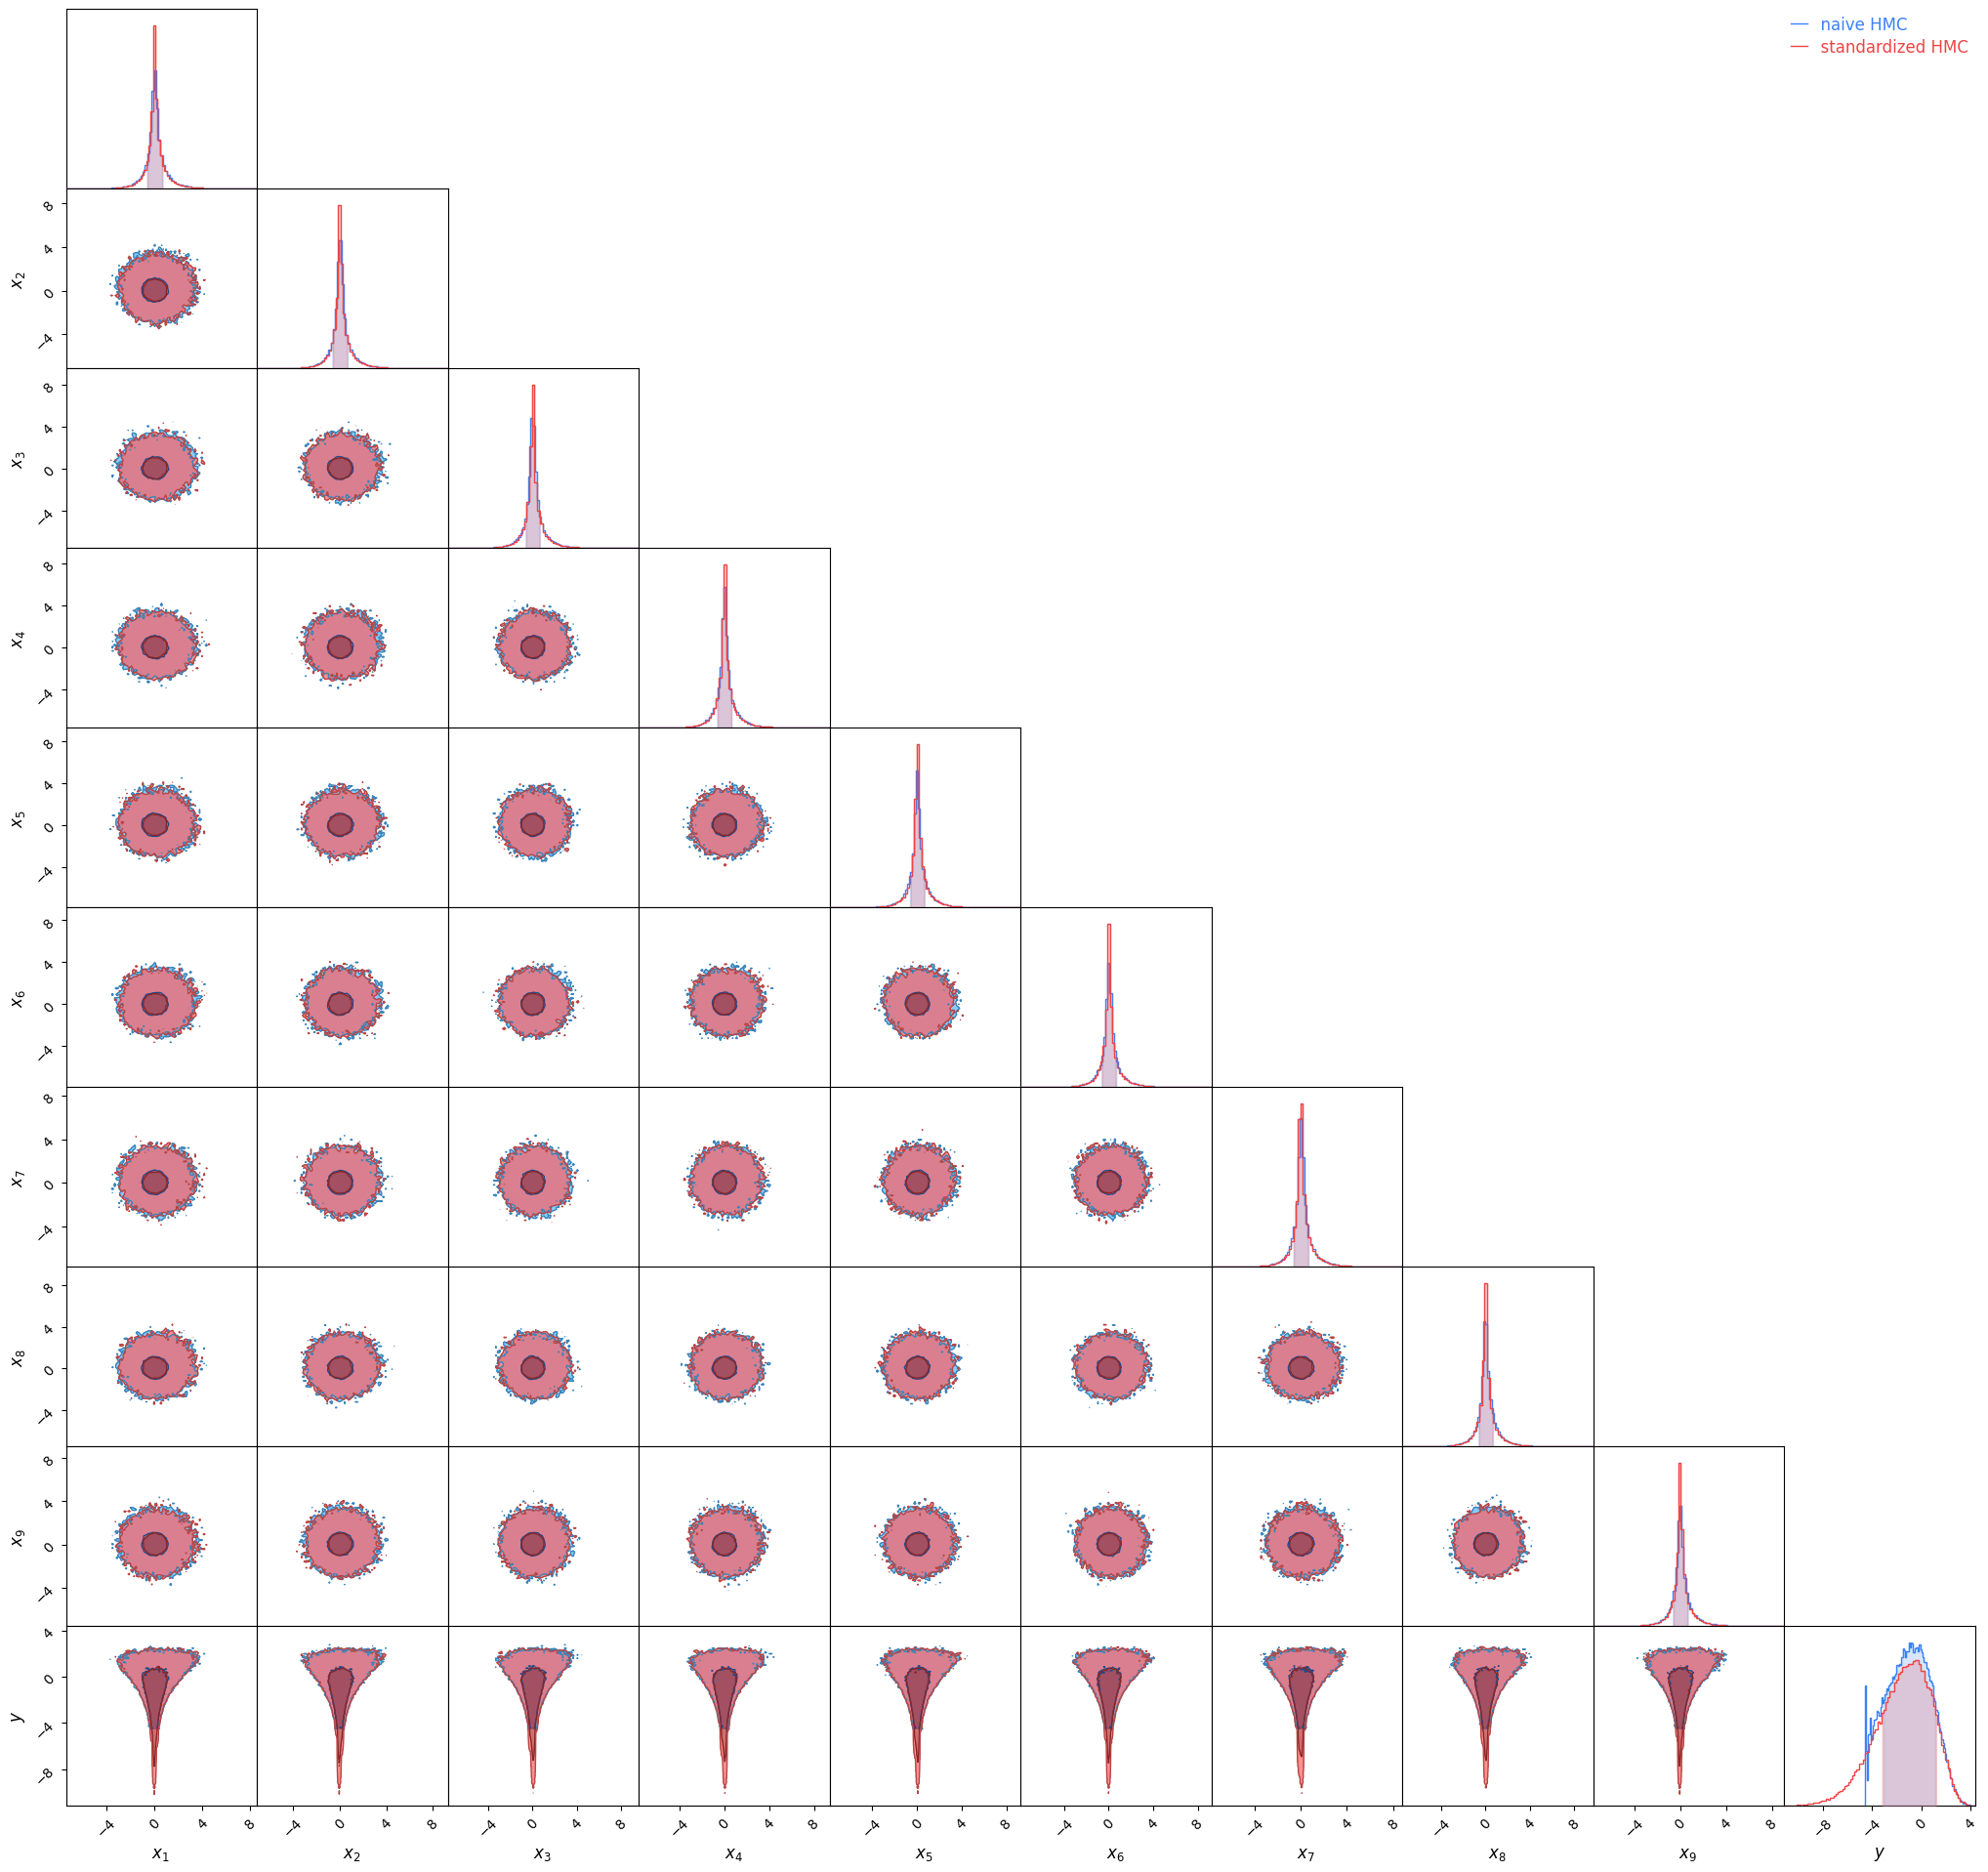

In [11]:
# plot funnel
cc = ChainConsumer()
standard_df = pd.DataFrame(standard_samples, columns=labels)
cc.add_chain(Chain(samples=df, name='naive HMC', smooth=0, color='blue'))
cc.add_chain(Chain(samples=standard_df, name='standardized HMC', smooth=0, color='red'))
fig = cc.plotter.plot()

## Two-stage sampling

We "over-parameterize" the hierarchical model:

\begin{align*}
    p(d | x_i): \; x_i \sim \,&\mathcal{N}(\mu=2, \sigma=5) \\
    p(x_i | \ln z_i): \; x_i \sim \,&\mathcal{N}(\mu=0, \sigma=z_i) \\
    p(\ln z_i): \; \ln z_i \sim \,&\text{Uniform}(-\infty, \infty) \\
\end{align*}

In [12]:
# extended sampling model
def extended_sampling_model():

    # log-uniform prior on z
    ln_z = numpyro.sample('ln_z', dist.Uniform(-6., 4.).expand((x_ndim,)))

    # prior on x
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_ndim,)))
    x = numpyro.deterministic('x', x_standard * jnp.exp(ln_z))

    # likelihood
    numpyro.factor('lnlike', lnlike(x))

extended_nuts_kernel = numpyro.infer.NUTS(model=extended_sampling_model,
                                          dense_mass=True)
extended_mcmc = numpyro.infer.MCMC(sampler=extended_nuts_kernel,
                                   num_warmup=int(1e5),
                                   num_samples=int(1e6))
extended_mcmc.run(jr.key(242))
extended_samples_dict = extended_mcmc.get_samples()
extended_samples = np.concatenate((extended_samples_dict['x'],
                                   extended_samples_dict['ln_z']), axis=1)

sample: 100%|██████████| 1100000/1100000 [19:26<00:00, 943.23it/s, 15 steps of size 2.72e-01. acc. prob=0.76]


Parameter $\ln z_2$ in chain extended HMC is not constrained
Parameter $\ln z_3$ in chain extended HMC is not constrained
Parameter $\ln z_4$ in chain extended HMC is not constrained
Parameter $\ln z_6$ in chain extended HMC is not constrained
Parameter $\ln z_9$ in chain extended HMC is not constrained


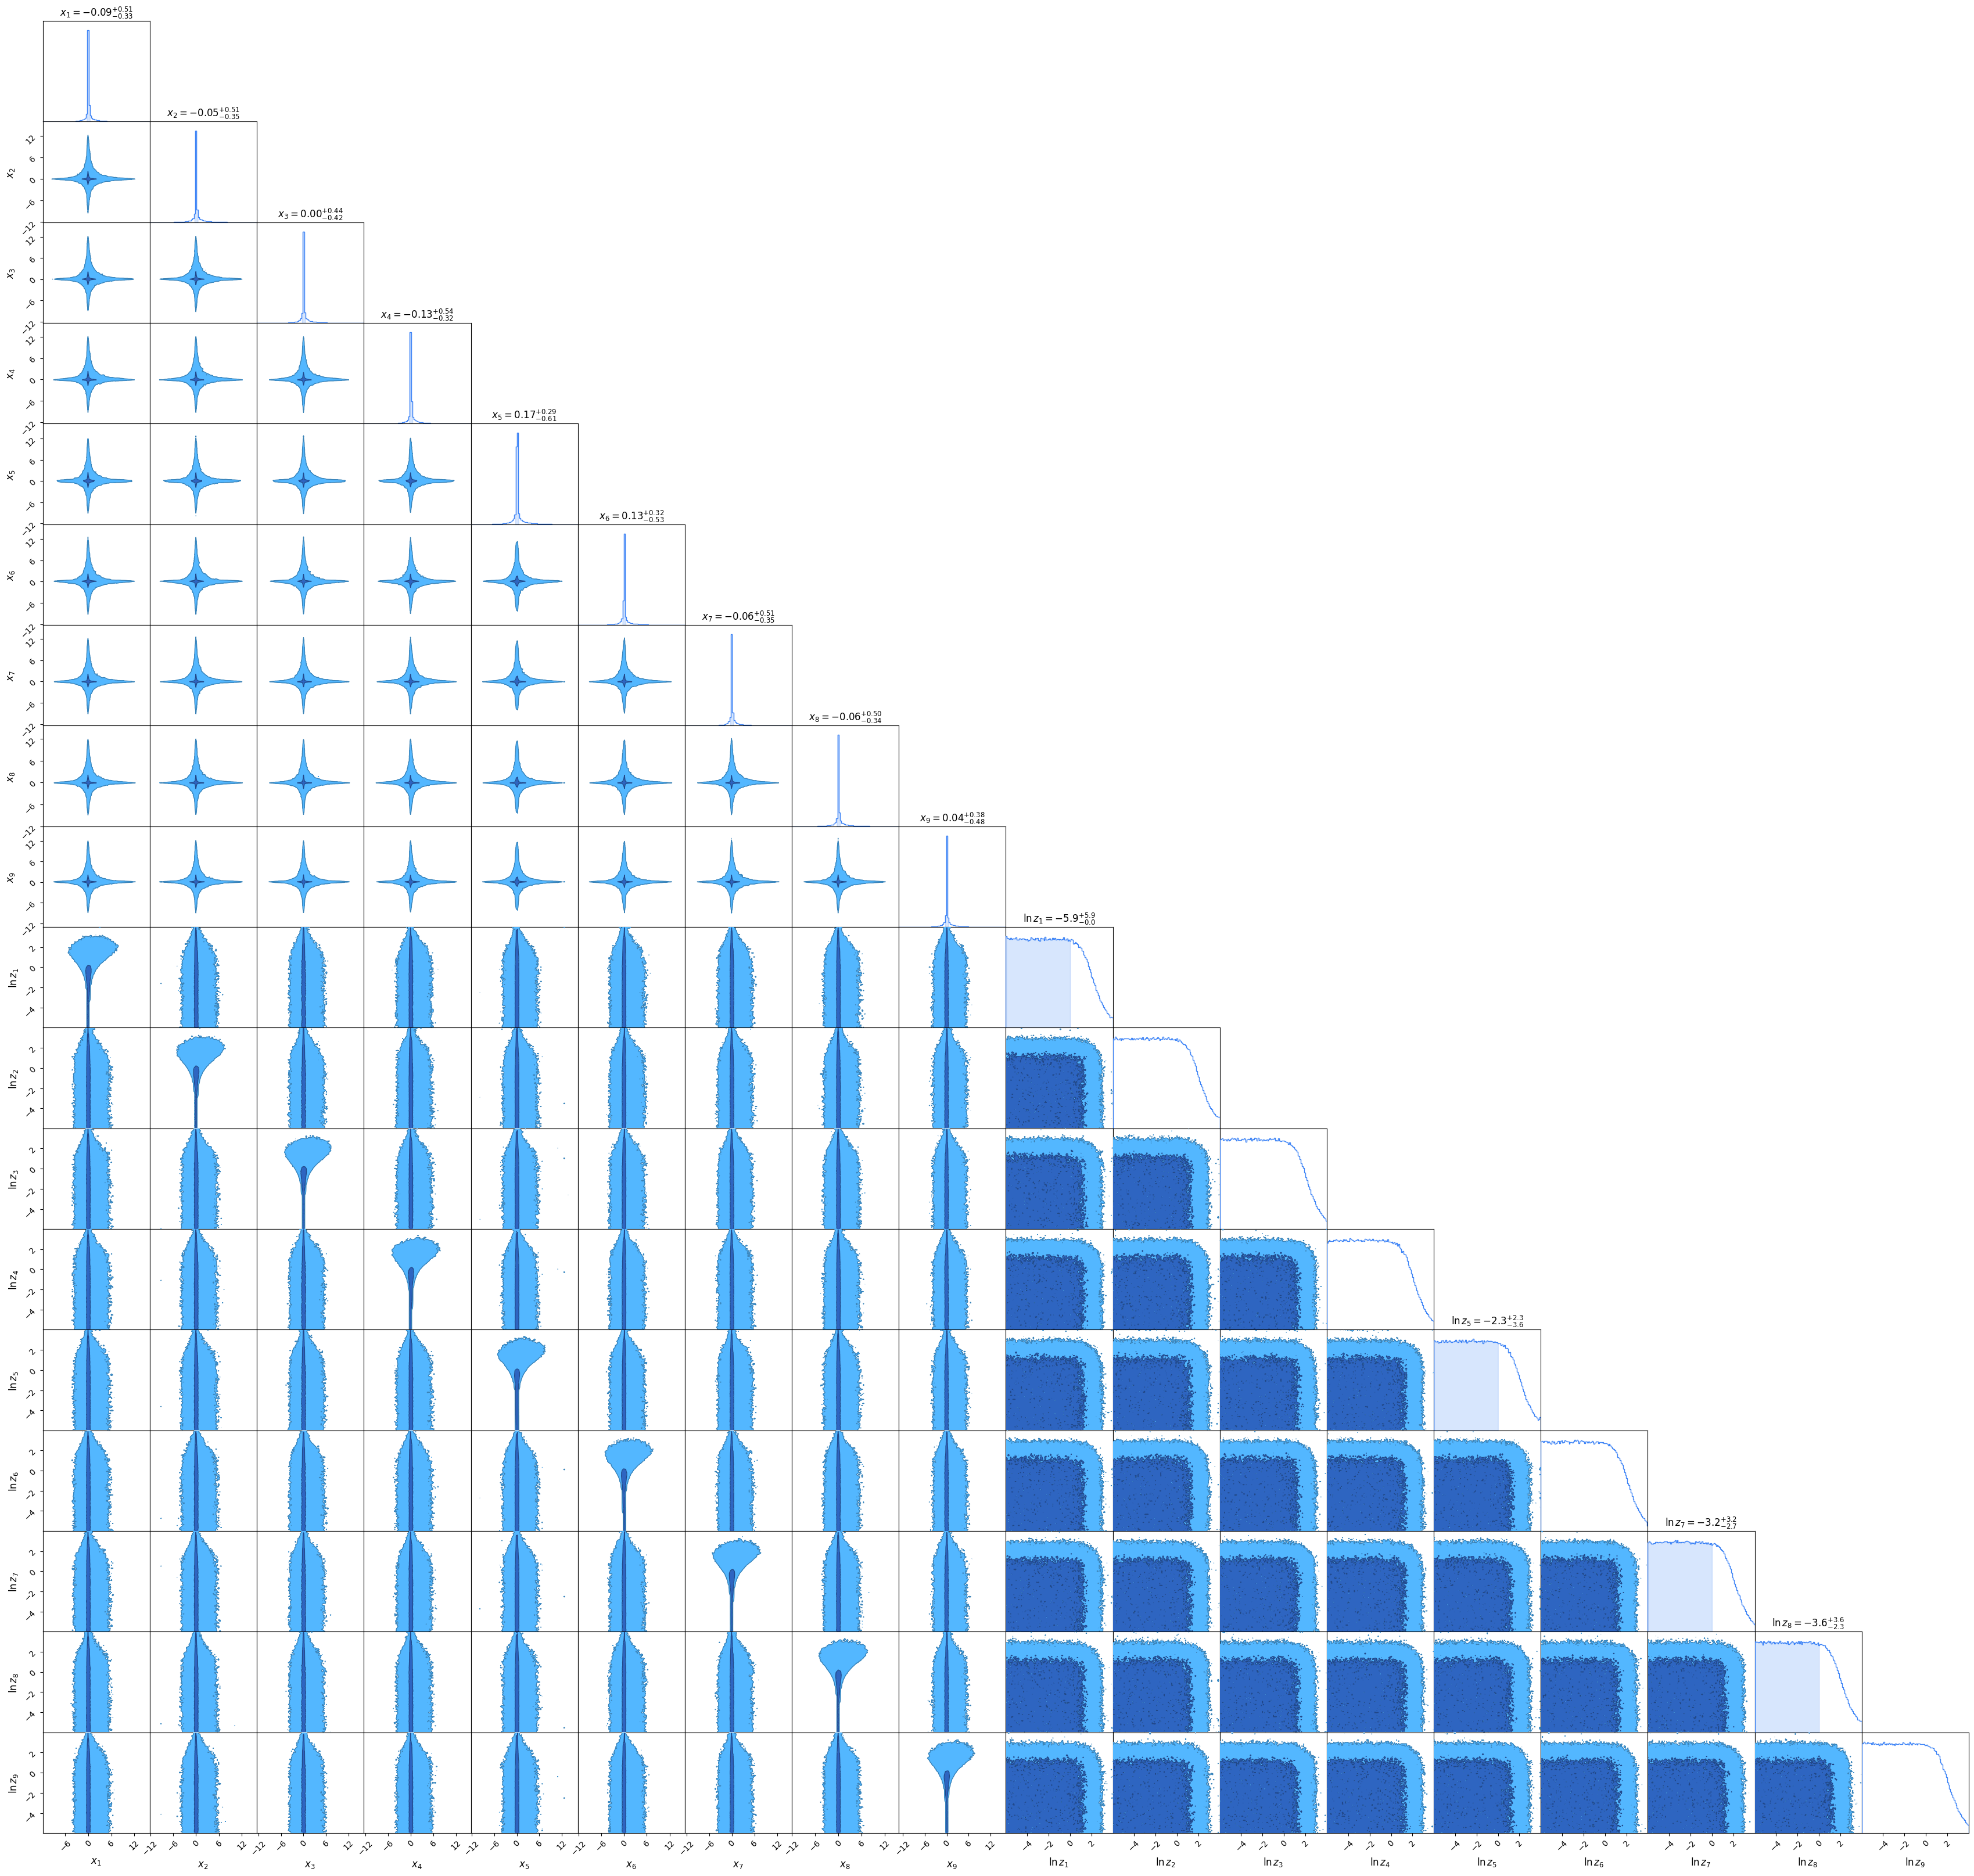

In [13]:
# plot test-tube
ln_z_labels = np.array([rf'$\ln z_{i}$' for i in range(1, x_ndim + 1)])
cc = ChainConsumer()
extended_df = pd.DataFrame(extended_samples, columns=np.concatenate((x_labels, ln_z_labels)))
cc.add_chain(Chain(samples=extended_df, name='extended HMC', smooth=0, color='blue'))
fig = cc.plotter.plot()

In [14]:
ln_z_samples = extended_samples_dict['ln_z']
ln_z_means = jnp.mean(ln_z_samples, axis=0)
L_cov = jnp.linalg.cholesky(jnp.cov(ln_z_samples.T))
inv_L_cov = jnp.linalg.inv(L_cov)

@jit
def standardize(ln_z_samples):
    return jnp.einsum('ij,ni->nj', inv_L_cov, (ln_z_samples - ln_z_means[None, :]))

@jit
def unstandardize(standard_samples):
    return ln_z_means[None, :] + jnp.einsum('ij,ni->nj', L_cov, standard_samples)

standard_ln_z_samples = standardize(ln_z_samples)

Parameter $\ln z_1$ in chain standard ln z is not constrained
Parameter $\ln z_2$ in chain standard ln z is not constrained
Parameter $\ln z_5$ in chain standard ln z is not constrained
Parameter $\ln z_6$ in chain standard ln z is not constrained
Parameter $\ln z_7$ in chain standard ln z is not constrained
Parameter $\ln z_9$ in chain standard ln z is not constrained


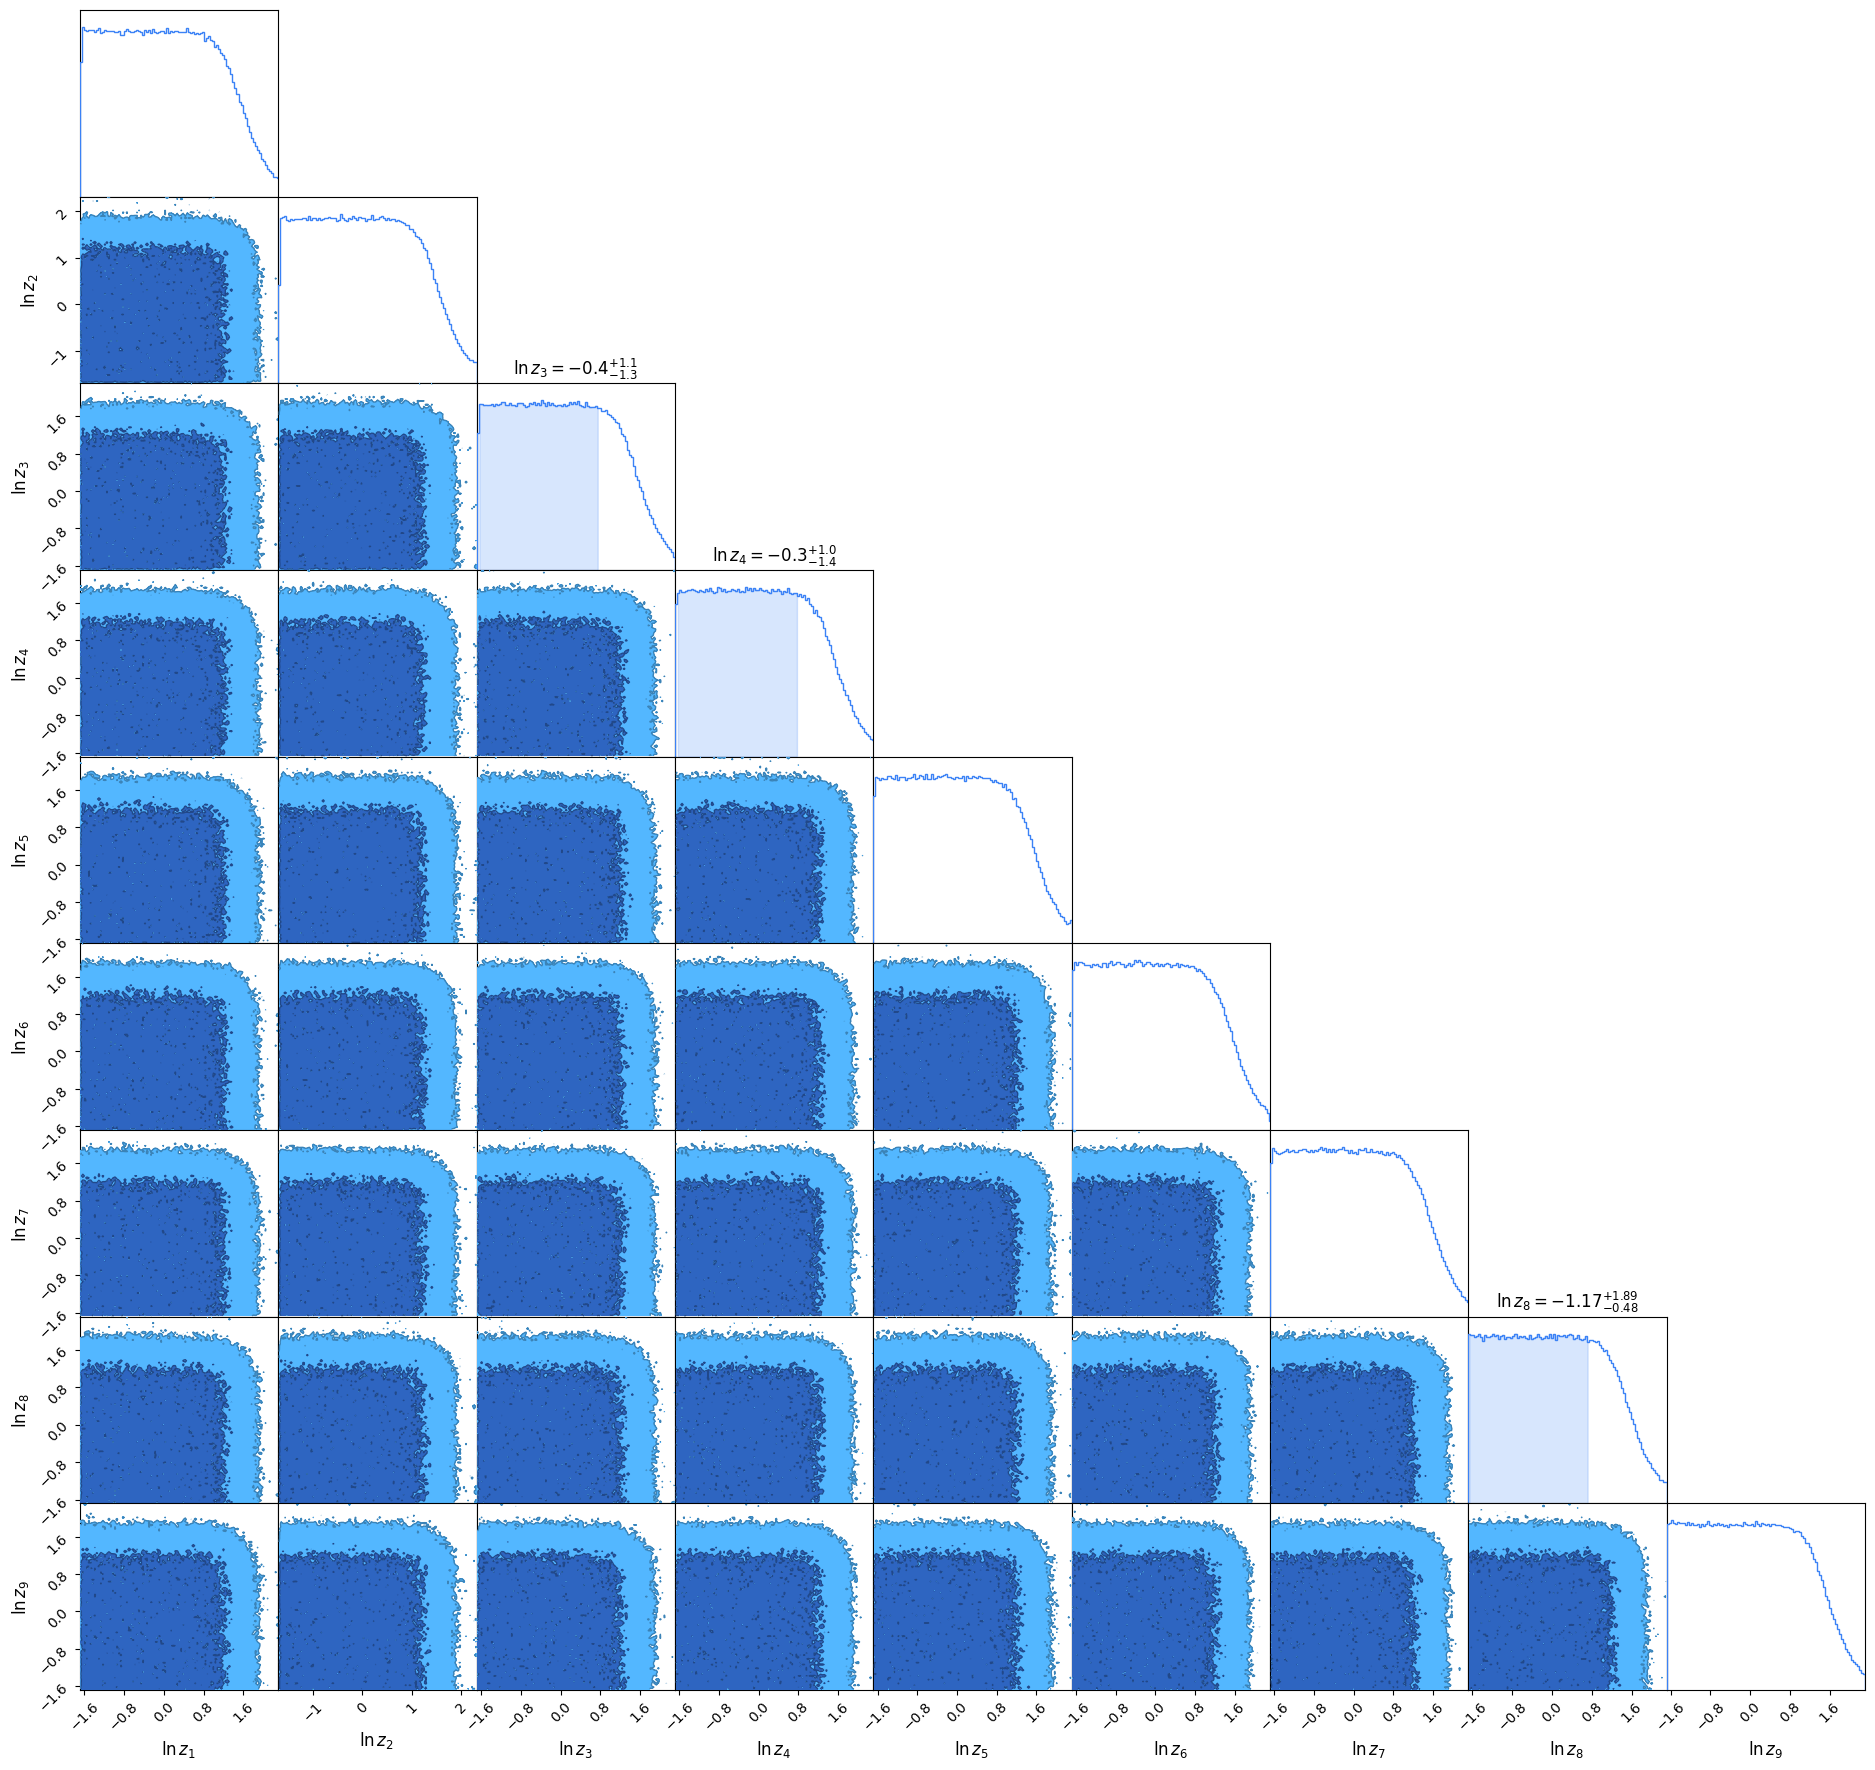

In [15]:
cc = ChainConsumer()
standard_ln_z_df = pd.DataFrame(standard_ln_z_samples, columns=ln_z_labels)
cc.add_chain(Chain(samples=standard_ln_z_df, name='standard ln z', smooth=0, color='blue'))
fig = cc.plotter.plot()

In [16]:
key, subkey = jr.split(jr.key(1))
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(ln_z_samples.shape[1]), scale=jnp.ones(ln_z_samples.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

In [17]:
key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, standard_ln_z_samples, learning_rate=1e-3, batch_size=1024)

 41%|████      | 41/100 [15:49<22:46, 23.15s/it, train=11.7, val=11.8 (Max patience reached)]


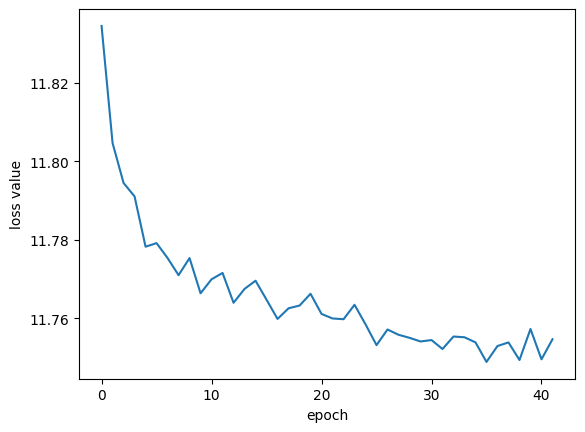

In [18]:
plt.plot(losses['val'])
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [19]:
standard_flow_samples = flow.sample(subkey, (500_000,))
flow_samples = unstandardize(standard_flow_samples)

Parameter $\ln z_1$ in chain normalizing flow is not constrained
Parameter $\ln z_2$ in chain HMC is not constrained
Parameter $\ln z_2$ in chain normalizing flow is not constrained
Parameter $\ln z_3$ in chain HMC is not constrained
Parameter $\ln z_3$ in chain normalizing flow is not constrained
Parameter $\ln z_4$ in chain HMC is not constrained
Parameter $\ln z_4$ in chain normalizing flow is not constrained
Parameter $\ln z_5$ in chain normalizing flow is not constrained
Parameter $\ln z_6$ in chain HMC is not constrained
Parameter $\ln z_6$ in chain normalizing flow is not constrained
Parameter $\ln z_7$ in chain normalizing flow is not constrained
Parameter $\ln z_8$ in chain normalizing flow is not constrained
Parameter $\ln z_9$ in chain HMC is not constrained
Parameter $\ln z_9$ in chain normalizing flow is not constrained


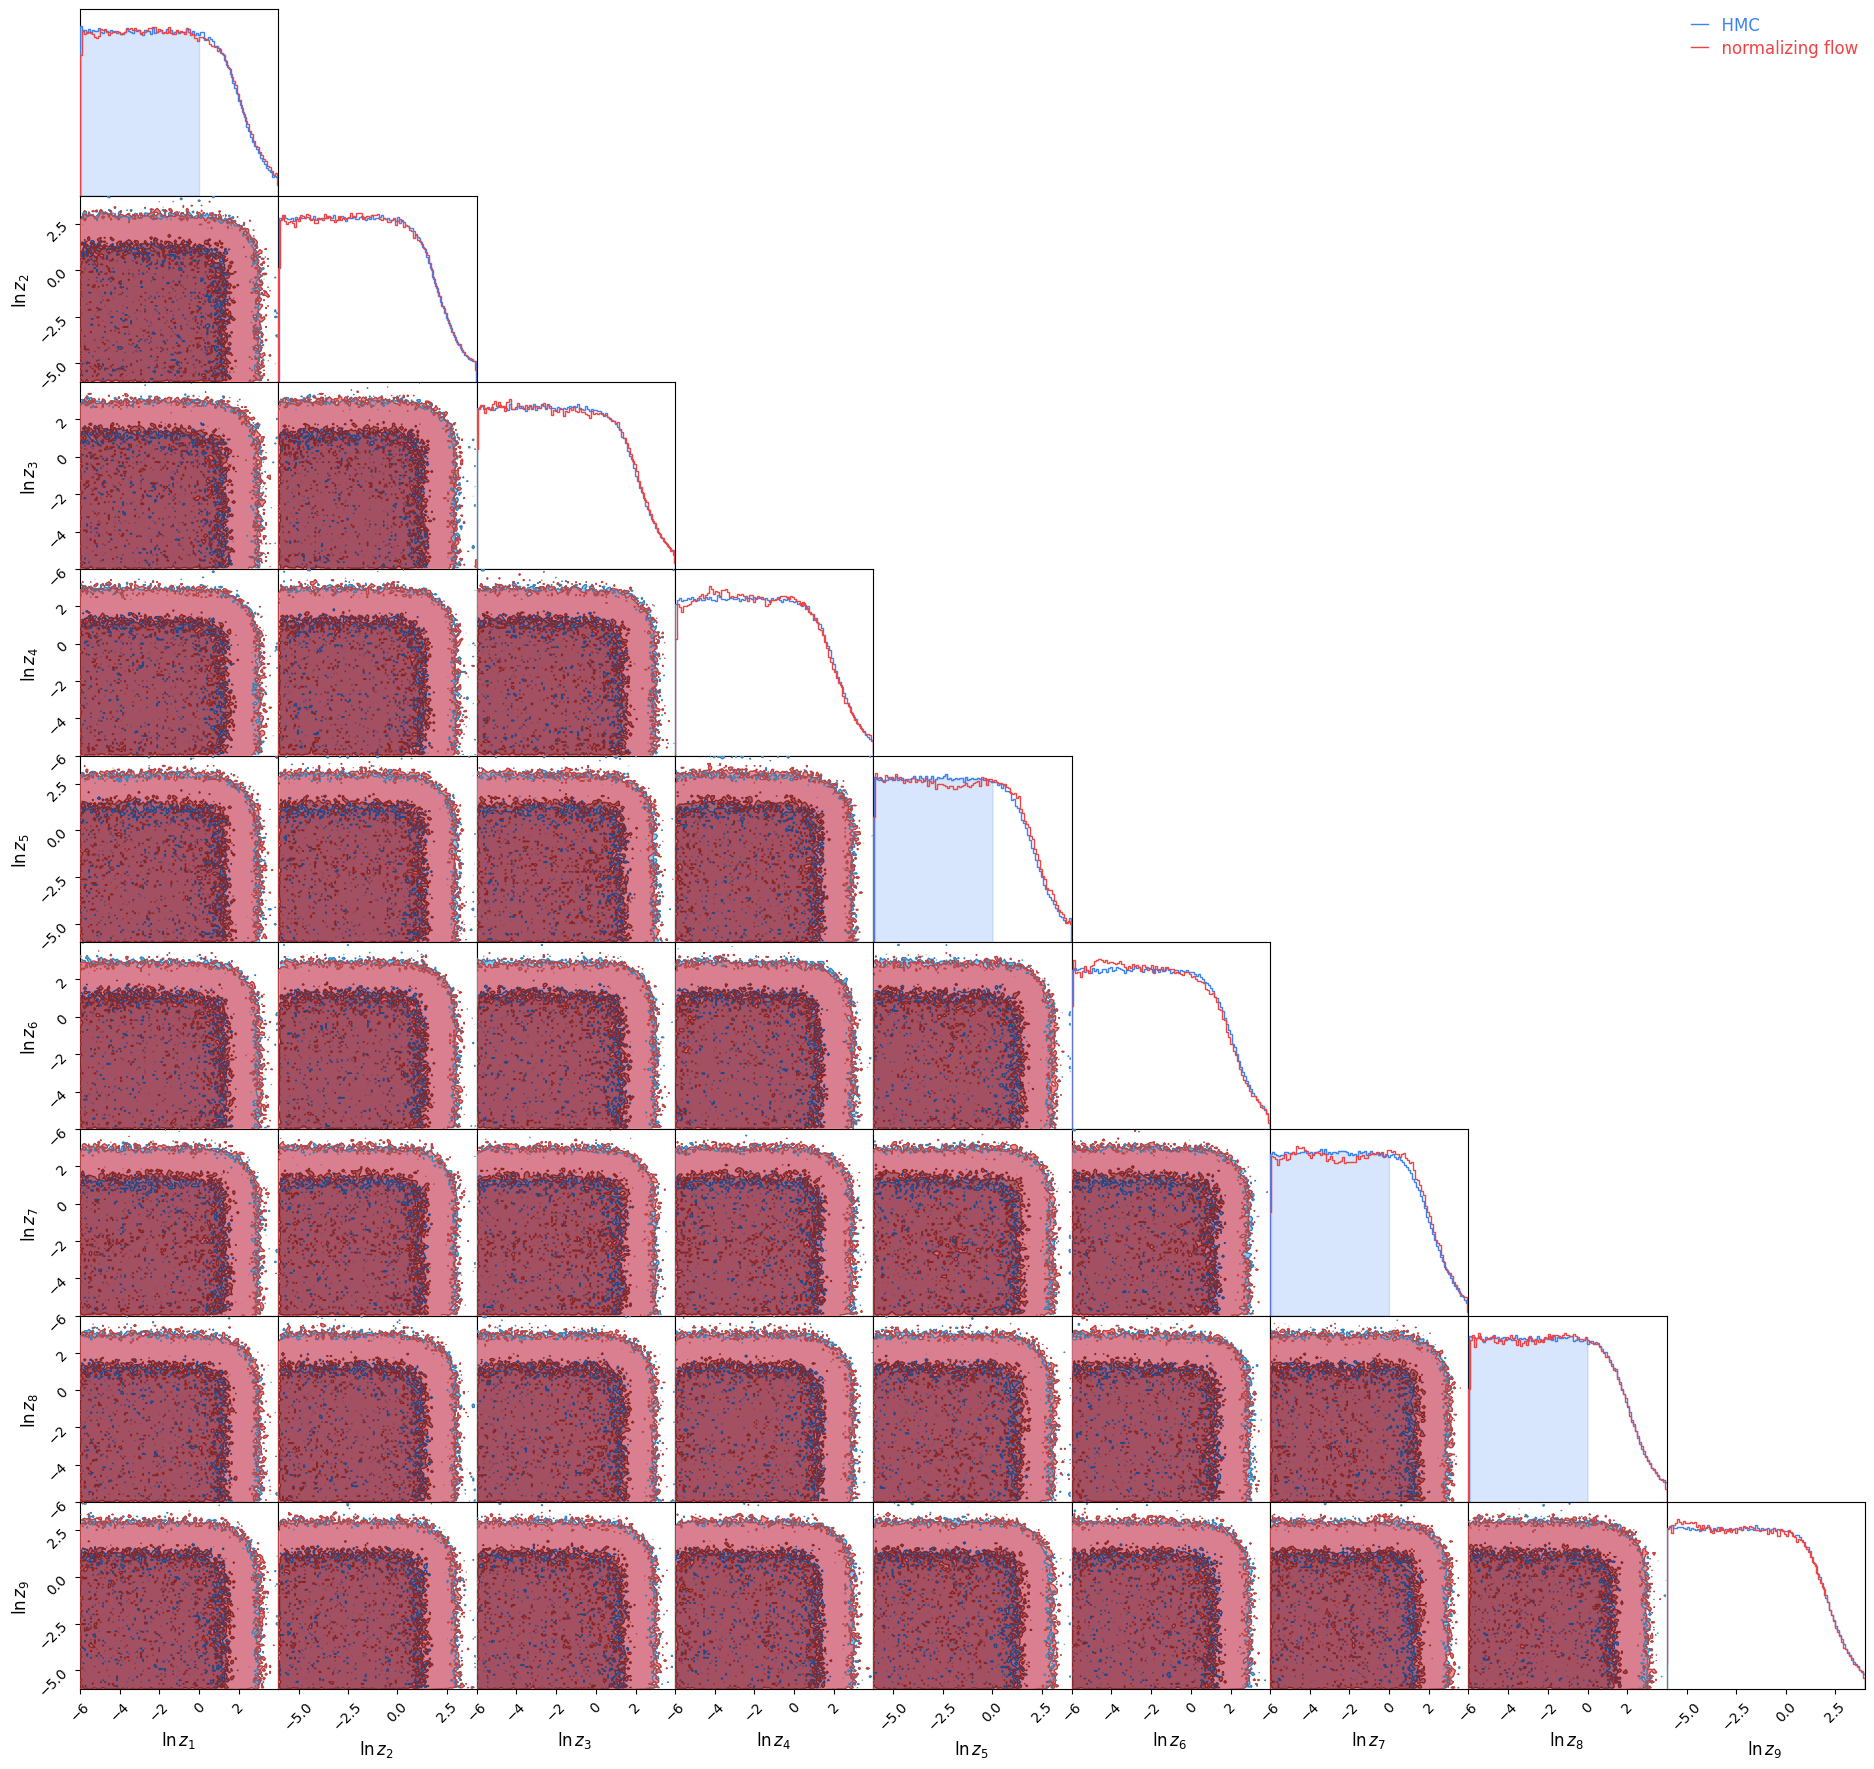

In [20]:
# plot test-tube
cc = ChainConsumer()
df_lnz = pd.DataFrame(ln_z_samples, columns=ln_z_labels)
df_flow = pd.DataFrame(flow_samples, columns=ln_z_labels)
cc.add_chain(Chain(samples=df_lnz, name='HMC', smooth=0, color='blue'))
cc.add_chain(Chain(samples=df_flow, name='normalizing flow', smooth=0, color='red'))
# cc.set_plot_config(PlotConfig(extents={label: (-12, 8) for label in ln_z_labels}))
fig = cc.plotter.plot()

In [21]:
# second stage likelihood
@jit
def second_lnlike(y):
    ln_z = jnp.ones(x_ndim) * y / 2
    ln_prob = flow.log_prob(standardize(ln_z))
    return ln_prob

In [22]:
# second stage sampling
def second_sampling_model():

    y_standard = numpyro.sample('y_standard', dist.Normal())
    y = numpyro.deterministic('y', hyper_prior_mean + hyper_prior_stdev * y_standard)
    numpyro.factor('lnlike', second_lnlike(y))


second_nuts_kernel = numpyro.infer.NUTS(model=second_sampling_model)
second_mcmc = numpyro.infer.MCMC(sampler=second_nuts_kernel,
                                 num_warmup=int(1e4),
                                 num_samples=int(1e5))
second_mcmc.run(jr.key(150914))
y_samples = second_mcmc.get_samples()['y']

sample: 100%|██████████| 110000/110000 [01:24<00:00, 1306.45it/s, 7 steps of size 8.80e-01. acc. prob=0.87]


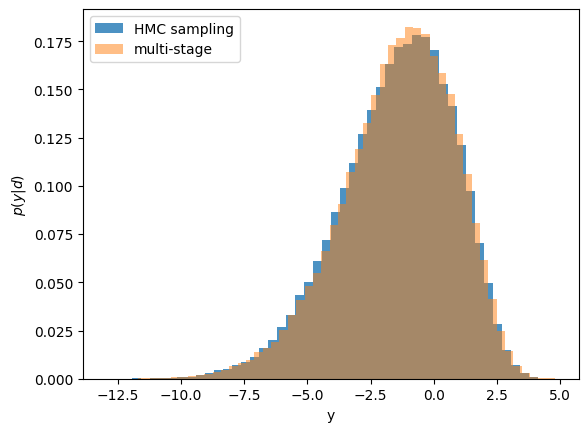

In [23]:
plt.hist(standard_samples_dict['y'], density=True, alpha=0.8, bins=50, label='HMC sampling')
plt.hist(y_samples, density=True, bins=50, label='multi-stage', alpha=0.5)
plt.xlabel('y')
plt.ylabel(r'$p(y | d)$')
plt.legend(loc='upper left')
plt.show()

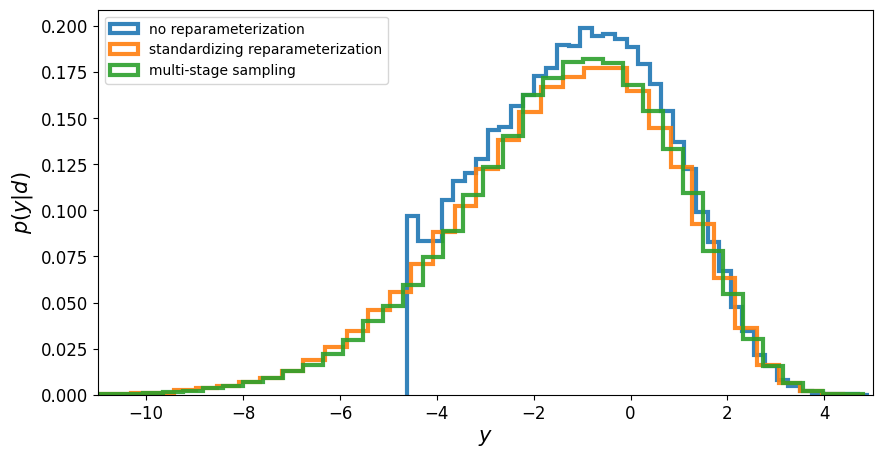

In [25]:
nbins = 40
plt.figure(figsize=(10, 5))
plt.hist(samples_dict['y'], bins=nbins, density=True, lw=3,
         label='no reparameterization', alpha=0.9, histtype='step')
plt.hist(standard_samples_dict['y'], bins=nbins, density=True, lw=3,
         label='standardizing reparameterization', alpha=0.9, histtype='step')
plt.hist(y_samples, bins=nbins, alpha=0.9, density=True,
         label='multi-stage sampling', histtype='step', lw=3)
plt.xlabel(r'$y$', fontsize=15)
plt.ylabel(r'$p(y | d)$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.xlim(-11., 5.)
plt.show()